<a href="https://colab.research.google.com/github/jihyuk1023/AI_physics/blob/main/08_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 dataset

이미지 분류를 위한 32*32 크기의 작은 데이터 셋입니다. MNIST처럼 CIFAR 역시 torchvision.dataset에서 다운 받을 수 있습니다. 

CIFAR dataset는 10개의 레이블을 가지고 있습니다. 
'plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck' 으로 구성된 데이터셋을 분류하는 문제입니다.

MNIST 처럼 CIFAR 10 데이터는 이미지 데이터입니다. 이미지 데이터는 각 데이터들이 공간상에서 관계를 가지고 있습니다. 즉, 가까운 데이터는 비슷한 값을 가질 확률이 높다는 뜻입니다.

우리가 이전에 학습한 FC Network는 이런 연관성을 반영하기 힘들었습니다.MNIST는 매우 잘 정돈된 데이터이기 때문에 괜찮지만, 데이터가 회전하거나, 평행 이동하거나 하는 등의 변화에 대해서 취약한 부분이 있습니다.
이러한 문제점을 해결하기 위해서 합성곱 신경망(Convolution Neural Network)가 고안되었습니다.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [ ]:
# data download . Transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(train_dataset.data.shape)

(50000, 32, 32, 3)


# Convolution 연산

CNN은 이미지 분류에 특화된 뉴럴 네트워크입니다. 주어진 계산들을 단순히 모두 연산에 사용하는 것이 아니라 데이터 사이의 관계를 이용하여 뉴럴 네트워크 층을 계산합니다. convolution 연산이 어떻게 이루어지는지 확인해봅시다.

우선, Filter라는 것을 정의하겠습니다.


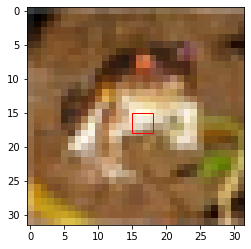

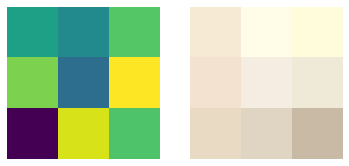

In [ ]:
import matplotlib.patches as patches
from matplotlib import gridspec


filter = np.random.uniform(0, 1, size = (3,3))
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(train_dataset.data[0,:,:,:]/ 255)
ax.add_patch(
     patches.Rectangle(
        (15, 15),
        3,
        3,
        edgecolor = 'red',
        fill=False))
plt.show()

fig, axes = plt.subplots(1,2)
axes[0].imshow(filter)
axes[0].axis(False)


image = train_dataset.data[0,15:18,15:18,:]
axes[1].imshow(image)
axes[1].axis(False)

plt.show()


[[[101  82 110]
  [143  71 160]
  [ 12 164 112]]

 [[100  79 108]
  [138  66 156]
  [ 11 152 110]]

 [[ 96  77 102]
  [126  59 134]
  [  9 121  85]]]


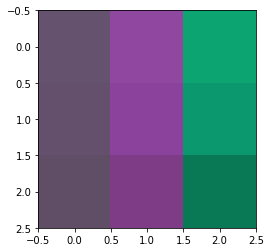

2684


In [ ]:
after_filter = (filter * train_dataset.data[0, 15:18, 15:18, :]).astype(int)
print(after_filter)

plt.imshow(after_filter)
plt.show()

Convolution = np.sum(after_filter)
print(Convolution)

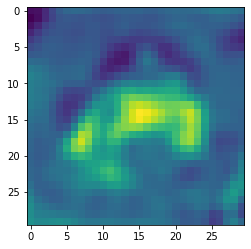

In [ ]:
new_tensor = torch.empty(30,30)
for i in range(30):
  for j in range(30):
    after_filter = (filter* train_dataset.data[0, i:i+3,j:j+3]).astype(int)
    Convolution = np.sum(after_filter)
    new_tensor[i,j] = Convolution

new_tensor = new_tensor / torch.max(new_tensor) * 255
plt.imshow(new_tensor)
plt.show()

# MaxPooling 연산

Maxpooling은 주어진 범위의 데이터 중 가장 큰 값을 출력하도록 만들어진 연산입니다. Maxpooling을 통과하면, 데이터 중에서 가장 큰 값을 가지는 값들만 남고 나머지 정보는 소실됩니다. 따라서 데이터의 크기가 줄어듭니다. 이 과정에서 데이터는 이미지의 특성들만을 저장하게 됩니다.

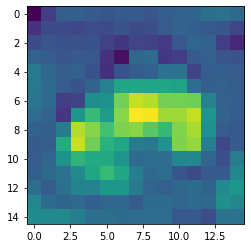

In [ ]:
max_pooled_tensor = torch.empty(15,15)
for i in range(15):
  for j in range(15):
    max_pooled = torch.max(new_tensor[2*i:2*(i+1), 2*j:2*(j+1)])
    max_pooled_tensor[i,j] = max_pooled

plt.imshow(max_pooled_tensor)
plt.show()

# Padding과 Stride

padding : convolution에서 줄어드는 차원을 보정하기 위해 맨 끝에 0을 포함하는 칸을 padding 개수만큼 추가.(zero padding)

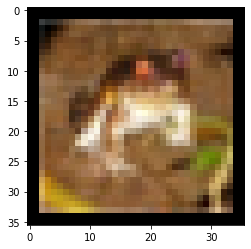

In [ ]:
new_shape = (train_dataset.data[0].shape[0] + 4, train_dataset.data[0].shape[1] + 4, train_dataset.data[0].shape[2])
padded_tensor = torch.zeros(new_shape)
padded_tensor[2:-2, 2:-2] = torch.tensor(train_dataset.data[0] / 255)
plt.imshow(padded_tensor)
plt.show()

stride : convolution을 stride 만큼씩 옮겨가며 계산 (코드에서는 2칸)

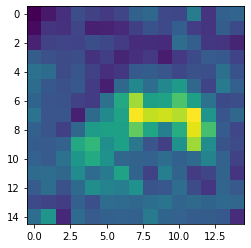

In [ ]:
new_tensor = torch.empty(15,15)
for i in range(15):
  for j in range(15):
    after_filter = (filter[2*i:2*i+3,2*j:2*j+3]* train_dataset.data[0, 2*i:2*i+3,2*j:2*j+3]).astype(int)
    Convolution = np.sum(after_filter)
    new_tensor[i,j] = Convolution

new_tensor = new_tensor / torch.max(new_tensor) * 255
plt.imshow(new_tensor)
plt.show()

# CNN이란?

CNN이란 이런 Convolution과 Maxpooling을 반복하여, 이미지를 인식합니다. Convolution을 사용하여 데이터의 특성을 추출하고, Maxpooling층을 통하여 그 정보들을 추상화합니다.
이 Convolution층을 여러개 통과시켜 추상화 된 데이터를 FC 층을 활용하여 처리하는 것입니다.

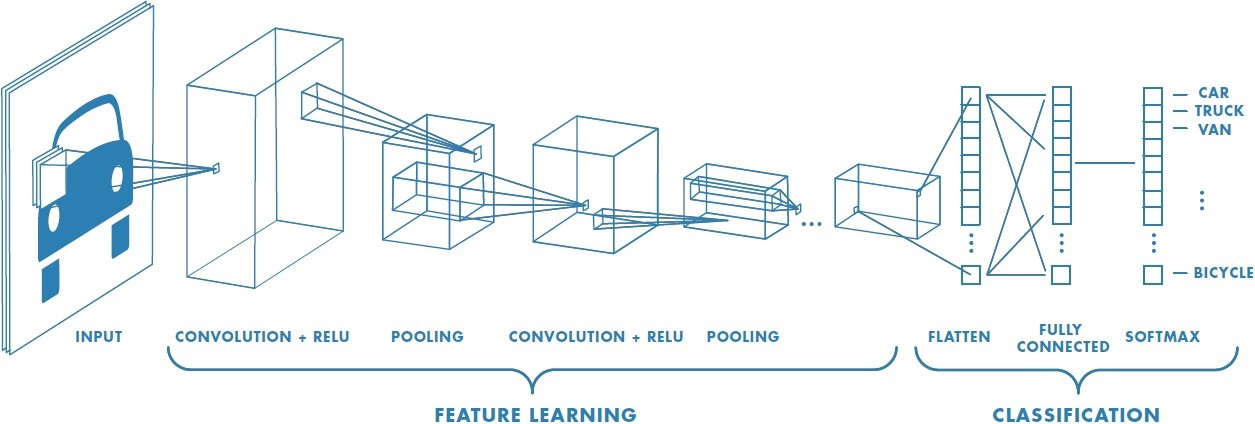

In [ ]:
path = '/content/CNN.jpeg'
from IPython.display import Image
Image(filename=path, width=1500)

이미지 출처 : https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148

relu : gradient vanishing을 줄이기 위한 activation function.

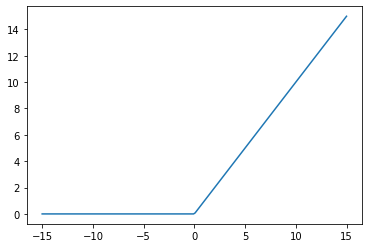

In [ ]:
x = np.linspace(-15,15, 200)
y = np.where(x>0, x, 0)

plt.plot(x, y)
plt.show()

# CNN 구현 - AlexNet


Network class -> __init__() / forward() 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

batch_size = 32

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, 5, padding=2) 
        self.conv2 = nn.Conv2d(48, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 192, 3, padding=1)
        self.conv4 = nn.Conv2d(192, 128, 3, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(48)
        self.batch_norm_2 = nn.BatchNorm2d(128)
        self.batch_norm_3 = nn.BatchNorm2d(192)
        self.batch_norm_4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*2*2, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm_1(self.conv1(x)))) # 32 * 32 -> 16 * 16
        x = self.pool(F.relu(self.batch_norm_2(self.conv2(x)))) # 16 * 16 -> 8
        x = self.pool(F.relu(self.batch_norm_3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm_4(self.conv4(x)))) # 128 * 2 * 2
        x = x.view(-1, 128*2*2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
net = Net()

In [ ]:
# fit 

# if torch.cuda.is_available():
#   device = torch.device("cuda:0")
# else:
#   device = torch.device("cpu")

net = Net()
if torch.cuda.is_available():
  net.to('cuda:0')
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method : Now SGD. 
optimizer = optim.Adam(net.parameters(), lr = 0.01)
# hyper-parameters
num_epochs = 1

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
for epoch in range(num_epochs):
  train_loss = 0
  train_total = 0  # 맞춘갯수
  for step, data in tqdm.tqdm(enumerate(train_loader)):
    x, label = data
    if torch.cuda.is_available():
        x = x.cuda()
        label = label.cuda()
    # grad init
    optimizer.zero_grad()

    # forward propagation
    output = net(x)
    # calculate loss
    loss = criterion(output, label)
    # back propagation 
    # autograd : 텐서에 연산을 가했을 때 그 gradient 
    loss.backward()
    # weight update
    optimizer.step()
    train_loss += loss.item()
    train_total += (torch.argmax(output, dim=1) == label).sum().item()
  train_loss = train_loss / len(train_loader)
  train_acc = train_total / len(train_dataset)

  #매 epoch이 끝날 때마다 validation을 진행합니다.
  with torch.no_grad():
    val_loss = 0.0
    total = 0
    for val_step, val in enumerate(val_loader):
      val_x, val_label = val
      if torch.cuda.is_available():
        val_x = val_x.cuda()
        val_label =val_label.cuda()
      val_output = net(val_x)
      v_loss = criterion(val_output, val_label)
      val_loss += v_loss
      total += (torch.argmax(val_output, dim=1) == val_label).sum().item()
    val_loss = val_loss / len(val_loader)
    val_acc = total/len(val_dataset)

  print("epoch: {}/{} | train loss: {} | val loss: {}".format(
                epoch+1, num_epochs, train_loss , val_loss))
  print("train acc : {}".format(train_acc))
  print("val_acc: {}".format(val_acc))        

  train_loss_history.append(train_loss)
  train_acc_history.append(train_acc)
  val_loss_history.append(val_loss)
  val_acc_history.append(val_acc)

1563it [00:20, 75.47it/s]


epoch: 1/1 | train loss: 2.022885786823485 | val loss: 1.9025558233261108
train acc : 0.19614
val_acc: 0.2245


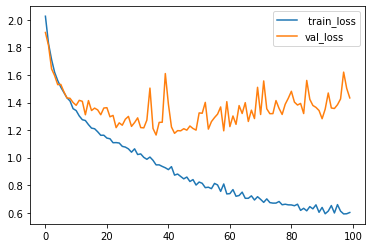

In [ ]:
plt.plot(train_loss_history, label = ' train_loss')
plt.plot(val_loss_history, label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
PATH = '/content/drive/My Drive/cifarcnn.h5'
torch.save(net.state_dict(), PATH)

# 층을 더 깊게.... VGG와 Gradient Vanishing

AlexNet은 5개의 Conv층을 활용해 만든, 분류문제에서 성과를 거둔 최초의 CNN입니다. 성능을 높이기 위해서 필터의 수와 레이어 층의 개수를 늘려가며 실험한 결과, 필터의 수보다는 레이어 층이 더 중요하다는 사실을 발견했습니다.
레이어 층이 많아질 수록 모델 성능이 올라가는 것을 확인하자(층이 너무 많지 않을 경우에는 사실입니다.), 사람들은 층을 늘리기 시작했습니다. VGG16은 16개 층, VGG19는 19개의 층을 사용하여 CNN의 성능을 높이는 데 성공했습니다.
그러나, 층을 무작정 늘린다고 문제가 해결되는 것은 아니였습니다. 문제는 크게 두가지 입니다.

1. 학습 시간의 문제

CNN 층이 늘어나면, 학습시켜야할 파라미터 수가 증가합니다. 이는 그래픽카드 램 용량 문제, overfitting 문제를 야기하며, 학습하는 데 걸리는 시간이 매우 증가하게 됩니다. 즉, 파라미터 수가 너무 늘어나지 않게 하는 방법이 필요했습니다.

2. Gradient Vanishing

두번째로는 층을 거듭할 수록 무조건 성능이 높아지는 것은 아니라는 것입니다. 층이 너무 많아지면 Gradient Vanishing 이라는 문제가 발생합니다. Gradient vanishing은 역전파 과정에서 gradient가 죽어서 잘 전달되지 않는 것입니다.

이 두 문제를 해결하기 위해 GoogleNet과 ResNet이 등장합니다.

# GoogleNet

1. 1X1 Convolution을 통한 parameter 수의 감소
2. 여러개의 Convolution의 합.


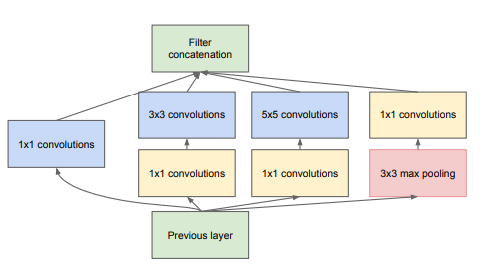

In [ ]:
path = '/content/주석 2020-05-28 112909.png'
from IPython.display import Image
Image(filename=path, width=700)

In [ ]:
class InceptionBlock(nn.Module):
  def __init__(self, input_filter, output_filter):
      super(InceptionBlock, self).__init__()
      self.input_filter = input_filter # RGB -> 3 
      self.output_filter = output_filter # 10
      self.conv_1 = nn.Conv2d(self.input_filter, self.output_filter, kernel_size = 1)
      self.conv_2_1 = nn.Conv2d(self.input_filter, self.output_filter, kernel_size = 1)
      self.conv_2_2 = nn.Conv2d(self.output_filter, self.output_filter, kernel_size = 3, padding = 1)
      self.conv_3_1 = nn.Conv2d(self.input_filter, self.output_filter, kernel_size = 1)
      self.conv_3_2 = nn.Conv2d(self.output_filter, self.output_filter, kernel_size = 5, padding = 2)
      self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=1, padding=1)
      self.conv_4_2 = nn.Conv2d(self.input_filter, self.output_filter, kernel_size = 1)
  
  def forward(self, x):
    conv_output_1 = self.conv_1(x)
    conv_output_2 = self.conv_2_2(self.conv_2_1(x))
    conv_output_3 = self.conv_3_2(self.conv_3_1(x))
    conv_output_4 = self.conv_4_2(self.max_pool(x))
    output = torch.cat([conv_output_1, conv_output_2,conv_output_3, conv_output_4], dim=1) #40개
    return output

In [ ]:
block = InceptionBlock(3, 10)
a = torch.empty([32,3,32,32])

In [ ]:
block.forward(a).shape

torch.Size([32, 40, 32, 32])

# ResNet

전 네트워크의 인풋을 다음 네트워크의 아웃풋에 더하는 형태입니다. 나중에 언급할 LSTM에서 아이디어를 얻은 네트워크입니다.
ResNet을 사용하면, 전 단계의 output이 유지되므로, gradient vanishing을 피할 수 있습니다.


In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, input_filter, output_filter, kernel_size):
      super(ResidualBlock, self).__init__()
      self.conv_1 = nn.Conv2d(input_filter, output_filter, kernel_size = kernel_size, padding = (kernel_size -1)//2, bias=False)
      self.BN_1 = nn.BatchNorm2d(output_filter)
      self.conv_2 = nn.Conv2d(output_filter, output_filter, kernel_size = kernel_size, padding = (kernel_size -1)//2, bias=False)
      self.BN_2 = nn.BatchNorm2d(output_filter)
  def forward(self, x):
    previous = x
    x = self.BN_2(self.conv_2(F.relu(self.BN_1(self.conv_1(x)))))
    output = x + previous
    return output

In [ ]:
block = ResidualBlock(3, 3, 5)
a = torch.empty([32,3,32,32])

In [ ]:
block.forward(a).shape

torch.Size([32, 13, 32, 32])